# Parameter-Tuning of time-varying volatility using Levy distribution (large $n$)

In [23]:
#Import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import levy
from scipy.special import erfc, erfinv, gamma, gammainc
import math
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
import time

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line


In [24]:
# some pandas option setting
pd.options.display.max_rows = 150

In [25]:
# python plot options
plt.rcParams['figure.dpi'] = 500

In [26]:
sys.path.append('../../tools')
import tools

In [27]:
importlib.reload(tools)

<module 'tools' from '../../tools/tools.py'>

## Estimating Time-varying Volatility

#### general set-up

In [28]:
# Paramater for t (here store as t)
ts  = np.array([0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])

S = np.array([1000])
Ns = np.array([5000000])

# Color for and types for graph
colors = ['r','g','b','black']
types = ['solid','dashed','dashdot','dotted']

### $c$ = $1.4*10**(-5)$

#### set-up


In [29]:
# Paramater for levy distribution
c = 1.4*10**(-5)
g = np.sqrt(c)

# True Levy distribution
f = levy.pdf(ts,  scale = c)
F = levy.cdf(ts,  scale = c)
sigma = tools.sigma_hat_t(f, F, g)



#### Estimation

* small N 

In [30]:
n = Ns[0]
a_ns = [
#     8*(n)**(1/5)/(max(ts) - min(ts)),
#     8*(n)**(1/4)/(max(ts) - min(ts)),
    8*(n)**(1/3)/(max(ts) - min(ts)),
    8*(n)**(1/2)/(max(ts) - min(ts)),
    8*(n)**(1/1)/(max(ts) - min(ts)),
    8*(n)**(2)/(max(ts) - min(ts)),
    8*(n)**(2.5)/(max(ts) - min(ts)),
    8*(n)**(3.0)/(max(ts) - min(ts)),
#     8*(n)**(3.5)/(max(ts) - min(ts)),
#     8*(n)**(4.0)/(max(ts) - min(ts)),
]

In [31]:
labels = [
#     r'$\frac{8 \times n^{\frac{1}{5}}}{C}$',
#     r'$\frac{8 \times n^{\frac{1}{4}}}{C}$',
    r'$\frac{8 \times n^{\frac{1}{3}}}{C}$',
    r'$\frac{8 \times n^{\frac{1}{2}}}{C}$',
     r'$\frac{8 \times n}{C}$',
     r'$\frac{8 \times n^{2}}{C}$',
    r'$\frac{8 \times n^{2.5}}{C}$',
    r'$\frac{8 \times n^{3}}{C}$',
#     r'$\frac{8 \times n^{3.5}}{C}$',
#     r'$\frac{8 \times n^{4}}{C}$',
    
]

In [32]:
deltas = (3/2)*np.array(a_ns)

In [ ]:
### for a_n
f_hats_ans = []
F_hats_ans = []
sigma_hats_ans  = []

### feasible and infeasible statistics
z_f_inf_ans = []
z_f_feas_ans = []

z_F_inf_ans = []
z_F_feas_ans  = []

z_sigma_inf_ans = []
z_sigma_feas_ans  = []


# for different a_n
for a_n_i, a_n in zip(range(0, len(a_ns)), a_ns):
 
    print(a_n)
    start_time = time.time()

    ### for different number of a_n
    f_hats_an  = []
    F_hats_an  = []
    sigma_hats_an   = []

    # feasible and infeasible statistics
    z_f_inf_an  = []
    z_f_feas_an  = []

    z_F_inf_an  = []
    z_F_feas_an  = []

    z_sigma_inf_an  = []
    z_sigma_feas_an   = []


    for t_i, t in zip(range(0, len(ts)),ts):

        # list to store the estimates
        f_hats = []
        F_hats = []

        # for each iteration
        for s in range(0, S[0]):

            # generate random sample
            t_g_w = levy.rvs(scale = c, size = n)

            # estimate f_hat and F_hat 
            f_hat = tools.f_hat_t(t, t_g_w, deltas[a_n_i])
            F_hat = tools.F_hat_t(t, t_g_w, deltas[a_n_i])   

            # store the estimates for this iteration
            f_hats.append(f_hat)
            F_hats.append(F_hat)


        # calculate sigma_hats
        f_hats = np.array(f_hats)
        F_hats = np.array(F_hats)
        sigma_hats = tools.sigma_hat_t(f_hats, F_hats, g)

        # infeasible and feasible statistics
        z_f_inf = np.sqrt((n/a_ns[a_n_i])*(1/f[t_i]))*(f_hats - f[t_i])
        z_f_feas = np.sqrt((n/a_ns[a_n_i])*(1/f_hats))*(f_hats - f[t_i])

        z_F_inf = np.sqrt((n/a_ns[a_n_i])*(1/F[t_i]))*(F_hats - F[t_i])
        z_F_feas = np.sqrt((n/a_ns[a_n_i])*(1/F_hats))*(F_hats - F[t_i])

        z_sigma_inf = np.sqrt((n/a_ns[a_n_i])*(((tools.fgW(tools.PgW_inv(F[t_i], g), g))**2)/f[t_i]))*(sigma_hats - sigma[t_i])
        z_sigma_feas = np.sqrt((n/a_ns[a_n_i])*(((tools.fgW(tools.PgW_inv(F_hats, g), g))**2)/f_hats))*(sigma_hats - sigma[t_i])

        # store the estimates
        f_hats_an.append(f_hats)
        F_hats_an.append(F_hats)
        sigma_hats_an.append(sigma_hats)

        z_f_inf_an.append(z_f_inf)
        z_f_feas_an.append(z_f_feas)

        z_F_inf_an.append(z_F_inf)
        z_F_feas_an.append(z_F_feas)

        z_sigma_inf_an.append(z_sigma_inf)
        z_sigma_feas_an.append(z_sigma_feas)
        
        
    # store the results with certain number of sample size
    f_hats_ans.append(f_hats_an)
    F_hats_ans.append(F_hats_an)
    sigma_hats_ans.append(sigma_hats_an)

    # feasible and infeasible statistics
    z_f_inf_ans.append(z_f_inf_an)
    z_f_feas_ans.append(z_f_feas_an)

    z_F_inf_ans.append(z_F_inf_an)
    z_F_feas_ans.append(z_F_feas_an)

    z_sigma_inf_ans.append(z_sigma_inf_an)
    z_sigma_feas_ans.append(z_sigma_feas_an)
    
    # print how much time it took to calculate for the current number of iterations
    end_time = time.time()   
    print(f"Time : {end_time - start_time} for a_n = {a_n}, n = {n}")


136.79808941394467


In [14]:
summary_stats = [np.nanmean, np.nanstd, 0.05, 0.95]
# in indices, add sample size and etc
summaries = []

# for different a_n
for a_n_i, a_n in zip(range(0, len(a_ns)), a_ns):
    
    ## access estimation for simulation with a particular sample size
    f_hats_an = f_hats_ans[a_n_i]
    F_hats_an = F_hats_ans[a_n_i]
    sigma_hats_an = sigma_hats_ans[a_n_i]

    # feasible and infeasible statistics
#     z_f_inf_iters = z_f_inf_ans[a_n_i]
#     z_f_feas_iters = z_f_feas_ans[a_n_i]

#     z_F_inf_iters = z_F_inf_ans[a_n_i]
#     z_F_feas_iters = z_F_feas_ans[a_n_i]

#     z_sigma_inf_iters = z_sigma_inf_ans[a_n_i]
#     z_sigma_feas_iters = z_sigma_feas_ans[a_n_i]
    

        
    # for each t, calculate summary statistics,
    for t_i, t in zip(range(0, len(ts)),ts):
        # store the estimates
        f_hats = f_hats_an[t_i]
        F_hats = F_hats_an[t_i]
        sigma_hats = sigma_hats_an[t_i]

        # ze stats
#         z_f_inf = z_f_inf_i[i]
#         z_f_feas = z_f_feas_i[i]

#         z_F_inf = z_F_inf_i[i]
#         z_F_feas = z_F_feas_i[i]

#         z_sigma_inf = z_sigma_inf_i[i]
#         z_sigma_feas = z_sigma_feas_i[i]

        ### calculate summary stats
        f_stats = tools.estimation_summary(f_hats, summary_stats, f[t_i],  rounding = 10)
        F_stats = tools.estimation_summary(F_hats, summary_stats, F[t_i], rounding = 10)
        sigma_stats = tools.estimation_summary(sigma_hats, summary_stats, sigma[t_i], rounding = 10)
        
        # ideal number
        f_stats = np.insert(f_stats, 0, f[t_i])
        F_stats = np.insert(F_stats, 0, F[t_i])
        sigma_stats = np.insert(sigma_stats, 0, sigma[t_i])
        
        

#         z_f_inf_stats = tools.estimation_summary(z_f_inf[~np.isinf(z_f_inf)], summary_stats, 0,  rounding = 10)
#         z_f_feas_stats = tools.estimation_summary(z_f_feas[~np.isinf(z_f_feas)], summary_stats, 0,  rounding = 10)

#         z_F_inf_stats = tools.estimation_summary(z_F_inf[~np.isinf(z_F_inf)], summary_stats, 0,  rounding = 10)
#         z_F_feas_stats = tools.estimation_summary(z_F_feas[~np.isinf(z_F_feas)], summary_stats, 0,  rounding = 10)

#         z_sigma_inf_stats = tools.estimation_summary(z_sigma_inf[~np.isinf(z_sigma_inf)], summary_stats, 0,  rounding = 10)
#         z_sigma_feas_stats = tools.estimation_summary(z_sigma_feas[~np.isinf(z_sigma_feas)], summary_stats, 0,  rounding = 10)


        # create a dataframe
        summary_t = pd.DataFrame([#f_stats, F_stats, 
                                  sigma_stats
                                 ],
                             columns = ['Target', 'Mean', 'Std', '5.0%', '95%'],
                             index = [np.tile(S,1),np.tile(n, 1),np.tile(labels[a_n_i], 1), np.tile(t, 1) , 
                                      [#'$\widehat{f}$', '$\widehat{F}$', 
                                        '$\widehat{\sigma}_{t,n}^f$',
                                        #'$Z_{t}^{f,inf}$', '$Z_{t}^{f,feas}$', 
                                        #'$Z_{t}^{F,inf}$', '$Z_{t}^{F,feas}$',
                                        #'$Z_{t}^{\sigma^f,inf}$', '$Z_{t}^{\sigma^f,feas}$'
                                      ]])



        summary_t.index.set_names(['S','n','$a_n$', 't', 'Statistics'], inplace = True)

        # store the summary
        summaries.append(summary_t)




In [15]:
pd.concat(summaries)

Target  \
S    n      $a_n$                                t         Statistics                           
1000 500000 $\frac{8 \times n^{\frac{1}{3}}}{C}$ 0.000001  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000010  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000100  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.001000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.010000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.100000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 1.000000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 10.000000 $\widehat{\sigma}_{t,n}^f$     1.0   
            $\frac{8 \times n^{\frac{1}{2}}}{C}$ 0.000001  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000010  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000100  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.001000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.010000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.100000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 1.000000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 10.000000 $\widehat{\sigma}_{t,n}^f$     1.0   
            $\frac{8 \times n}{C}$               0.000001  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000010  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000100  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.001000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.010000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.100000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 1.000000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 10.000000 $\widehat{\sigma}_{t,n}^f$     1.0   
            $\frac{8 \times n^{2}}{C}$           0.000001  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000010  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000100  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.001000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.010000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.100000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 1.000000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 10.000000 $\widehat{\sigma}_{t,n}^f$     1.0   
            $\frac{8 \times n^{2.5}}{C}$         0.000001  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000010  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.000100  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.001000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.010000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 0.100000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 1.000000  $\widehat{\sigma}_{t,n}^f$     1.0   
                                                 10.000000 $\widehat{\sigma}_{t,n}^f$     1.0   
            $

### Plots

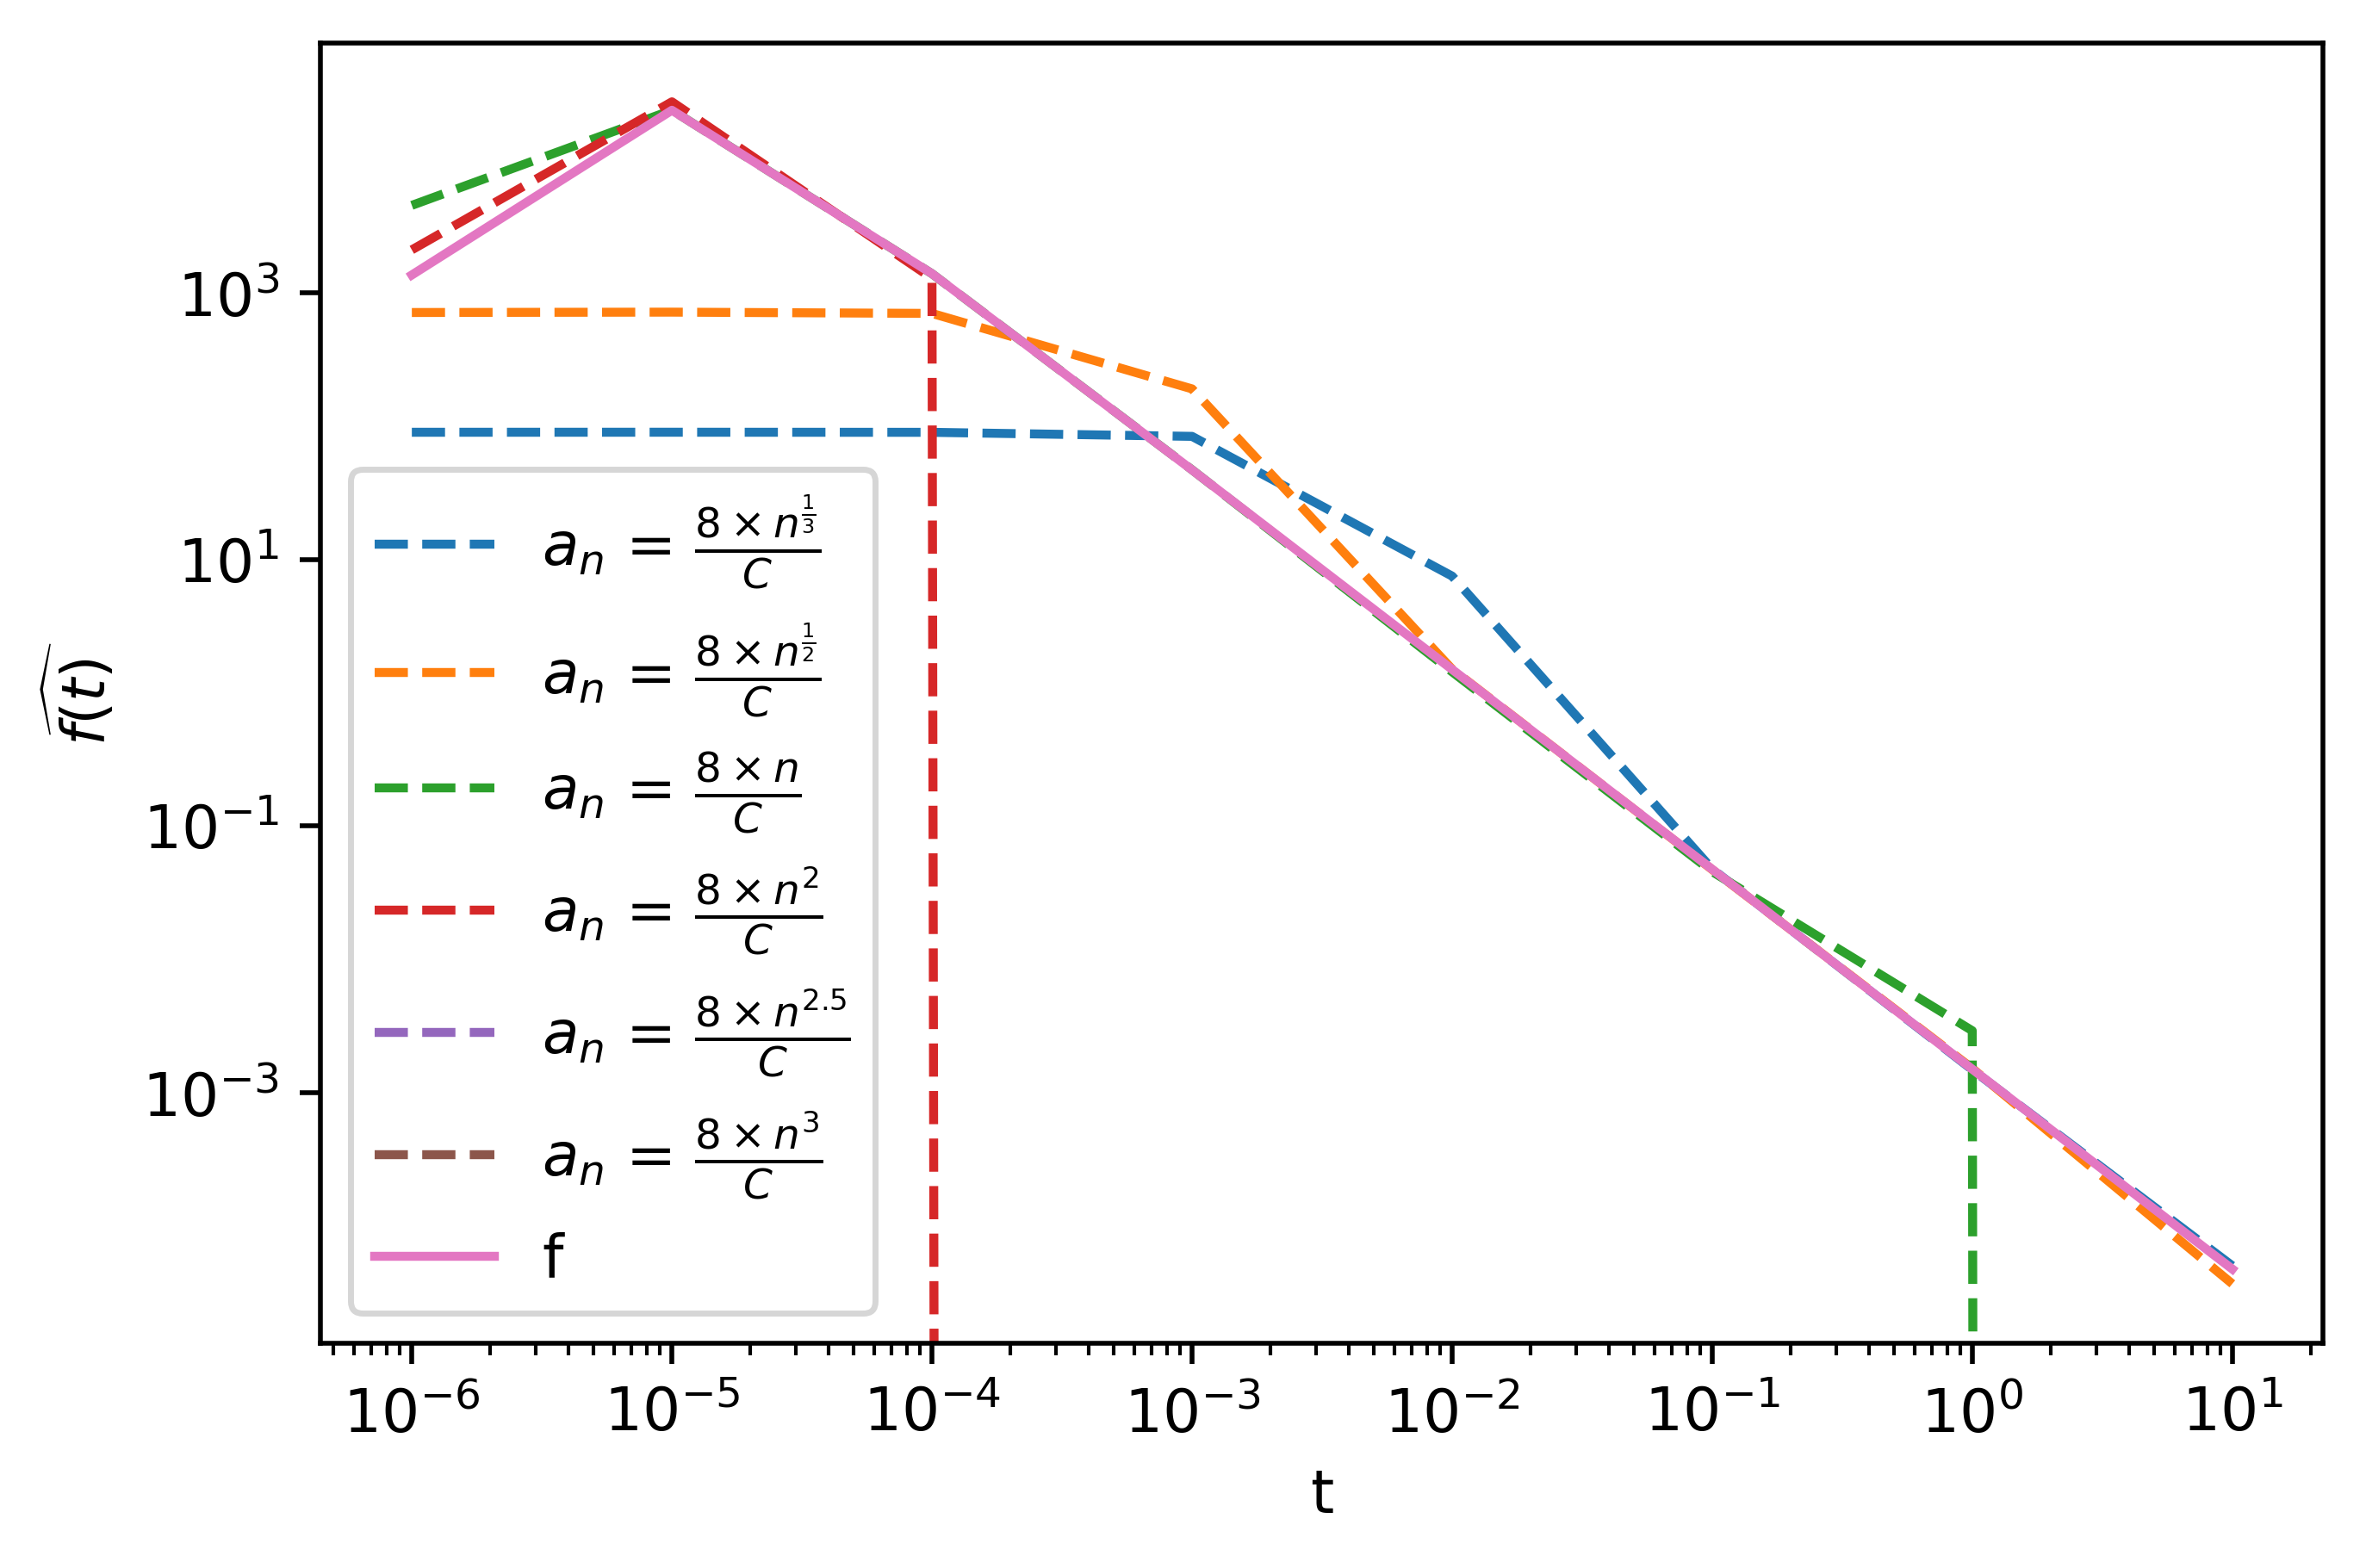

In [16]:
for i in range(0, len(a_ns)):
    
    plt.plot(ts, np.nanmean(f_hats_ans[i], axis = 1), label = f'$a_n$ = {labels[i]}', linestyle = types[1])
    plt.xlabel('t')
    plt.ylabel('$\widehat{f(t)}$')

plt.plot(ts, f,
        label = 'f')
    
plt.legend()
plt.xscale('log')
plt.yscale('log')


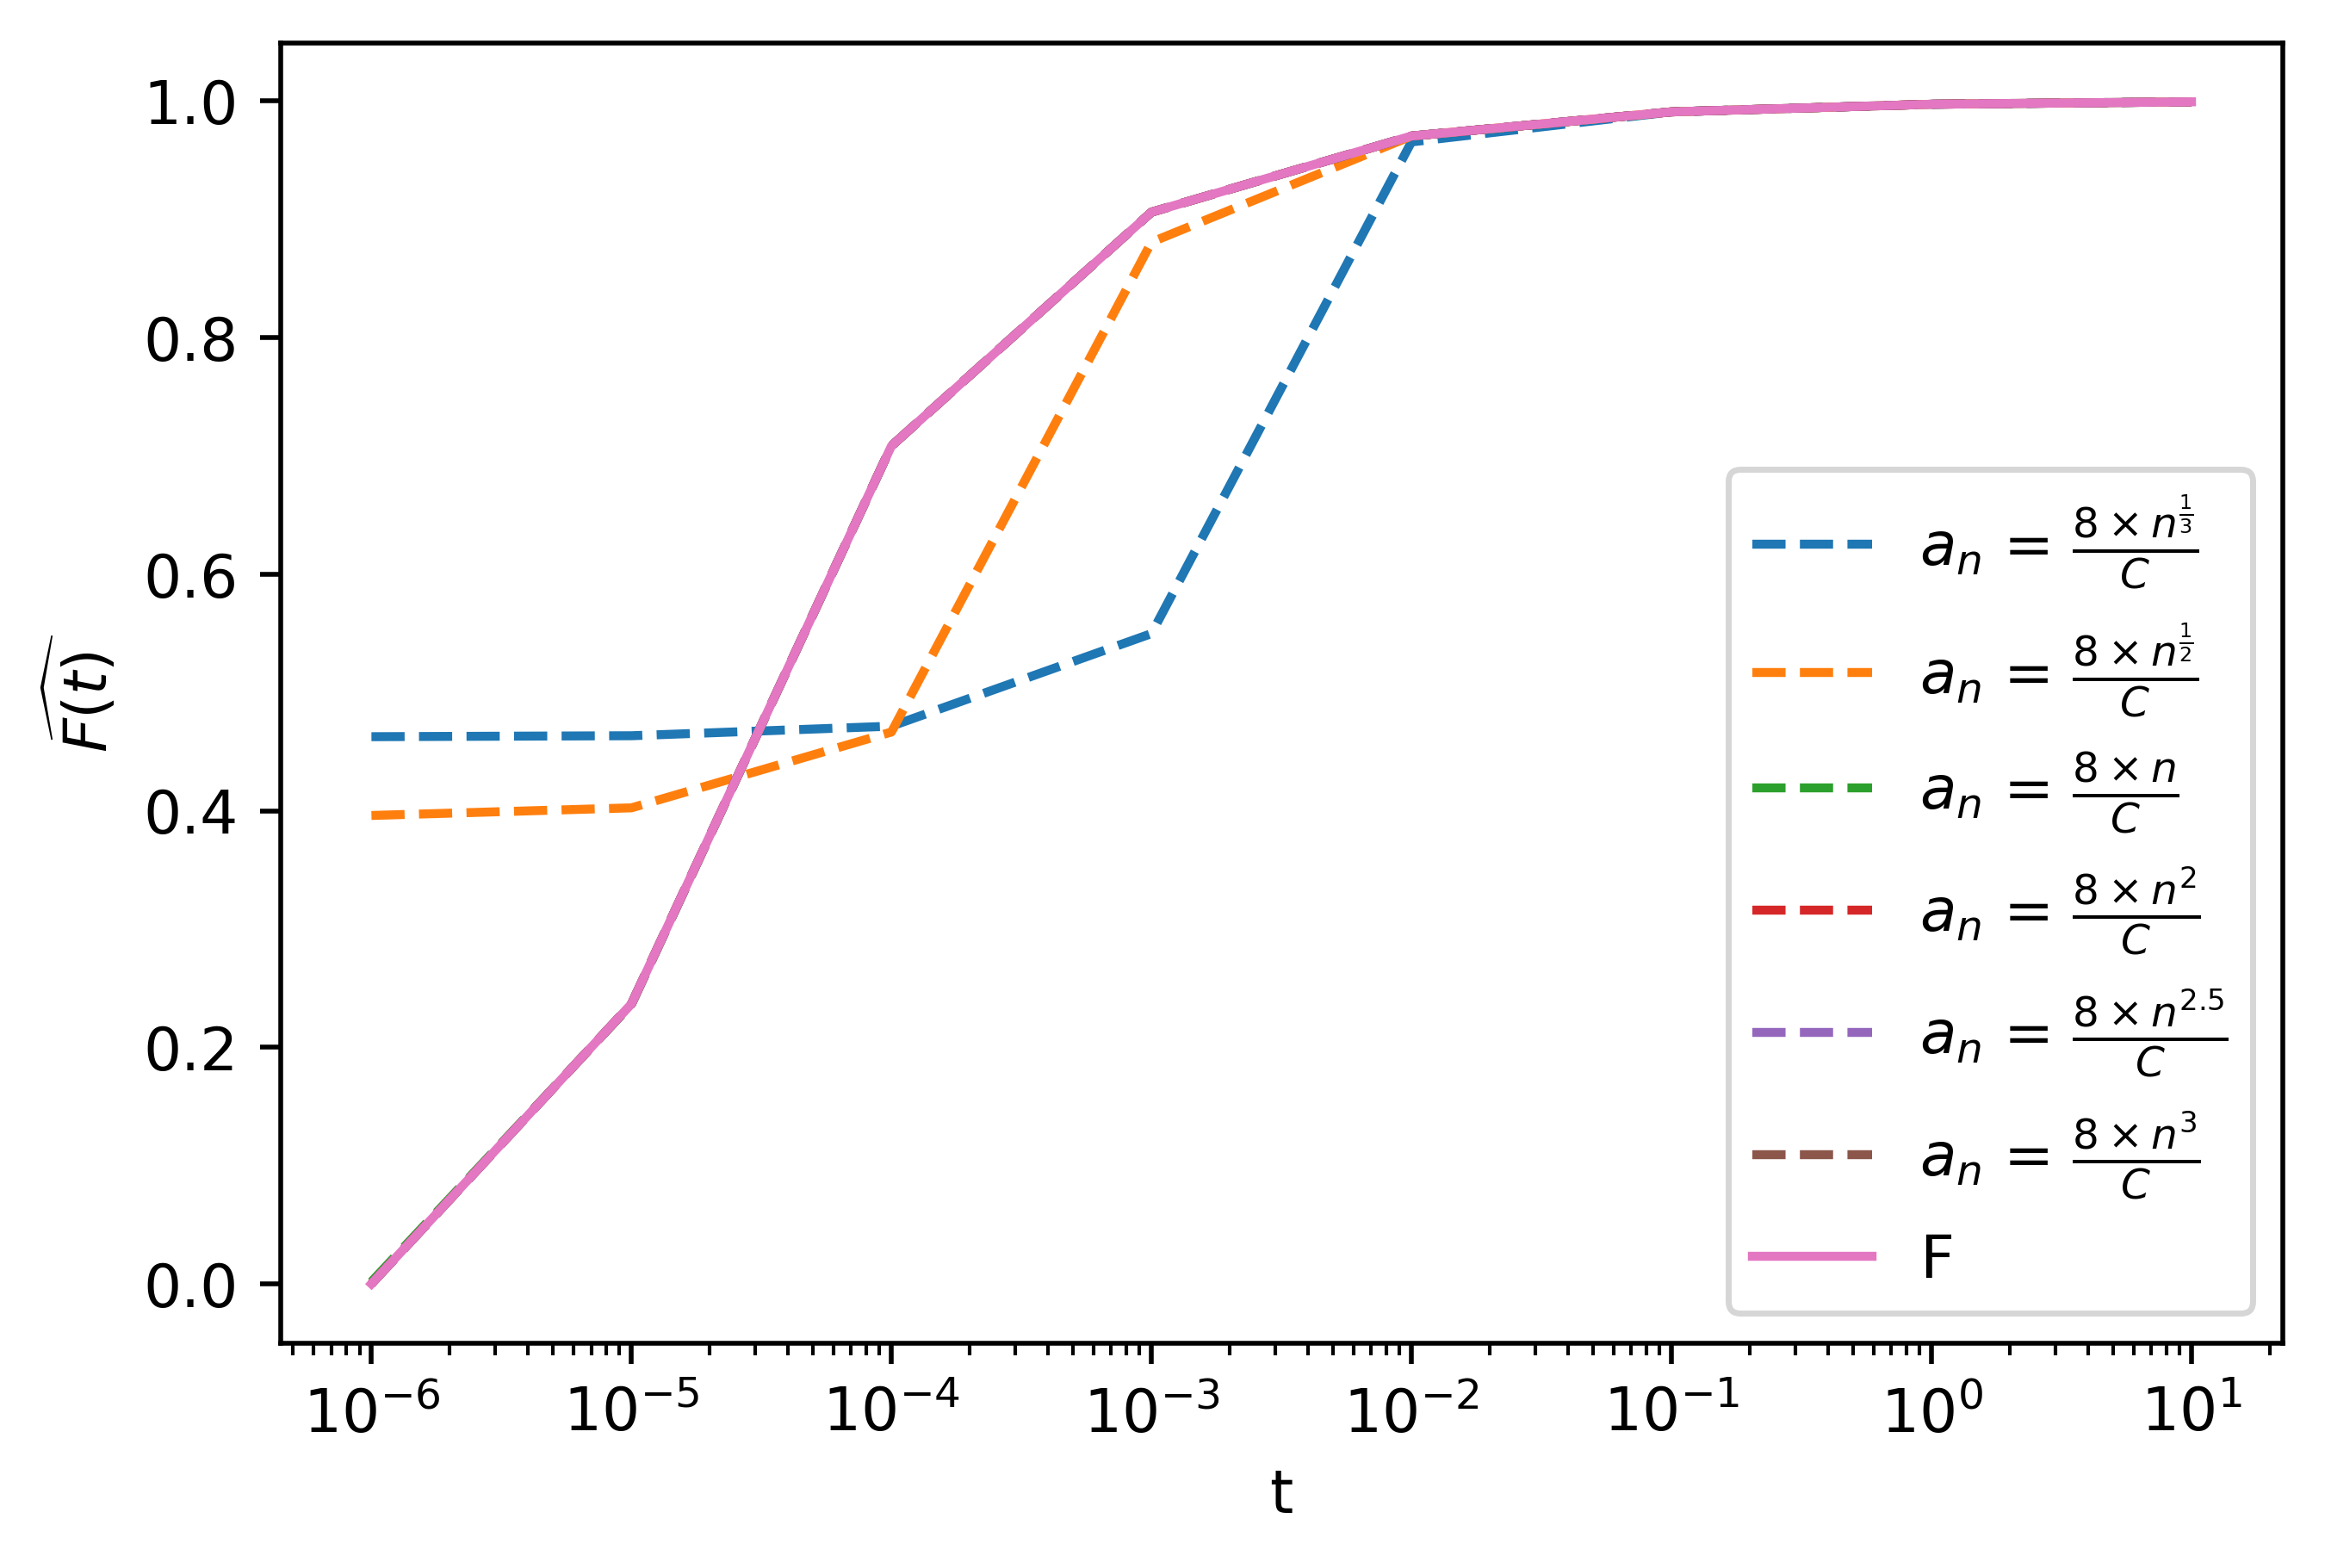

In [17]:
for i in range(0, len(a_ns)):
    
    plt.plot(ts, np.nanmean(F_hats_ans[i], axis = 1), label = f'$a_n$ = {labels[i]}', linestyle = types[1])
    plt.xlabel('t')
    plt.ylabel('$\widehat{F(t)}$')

plt.plot(ts, F,
        label = 'F')
    
plt.legend()
plt.xscale('log')

[0.01041299 0.01046655 0.0109289  0.01639882 3.15732824 1.00326899
 0.99461666 1.07142485]
[0.05852305 0.06076437 0.08297894 1.98437197 1.00210892 0.9943636
 1.01101793 0.76502035]
[0.6434297  1.00008006 0.99974634 1.0011173  0.96100182 0.95974399
 1.85451523 0.        ]
[1.49528202 1.15638807 0.92717562 0.         0.         0.
 0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


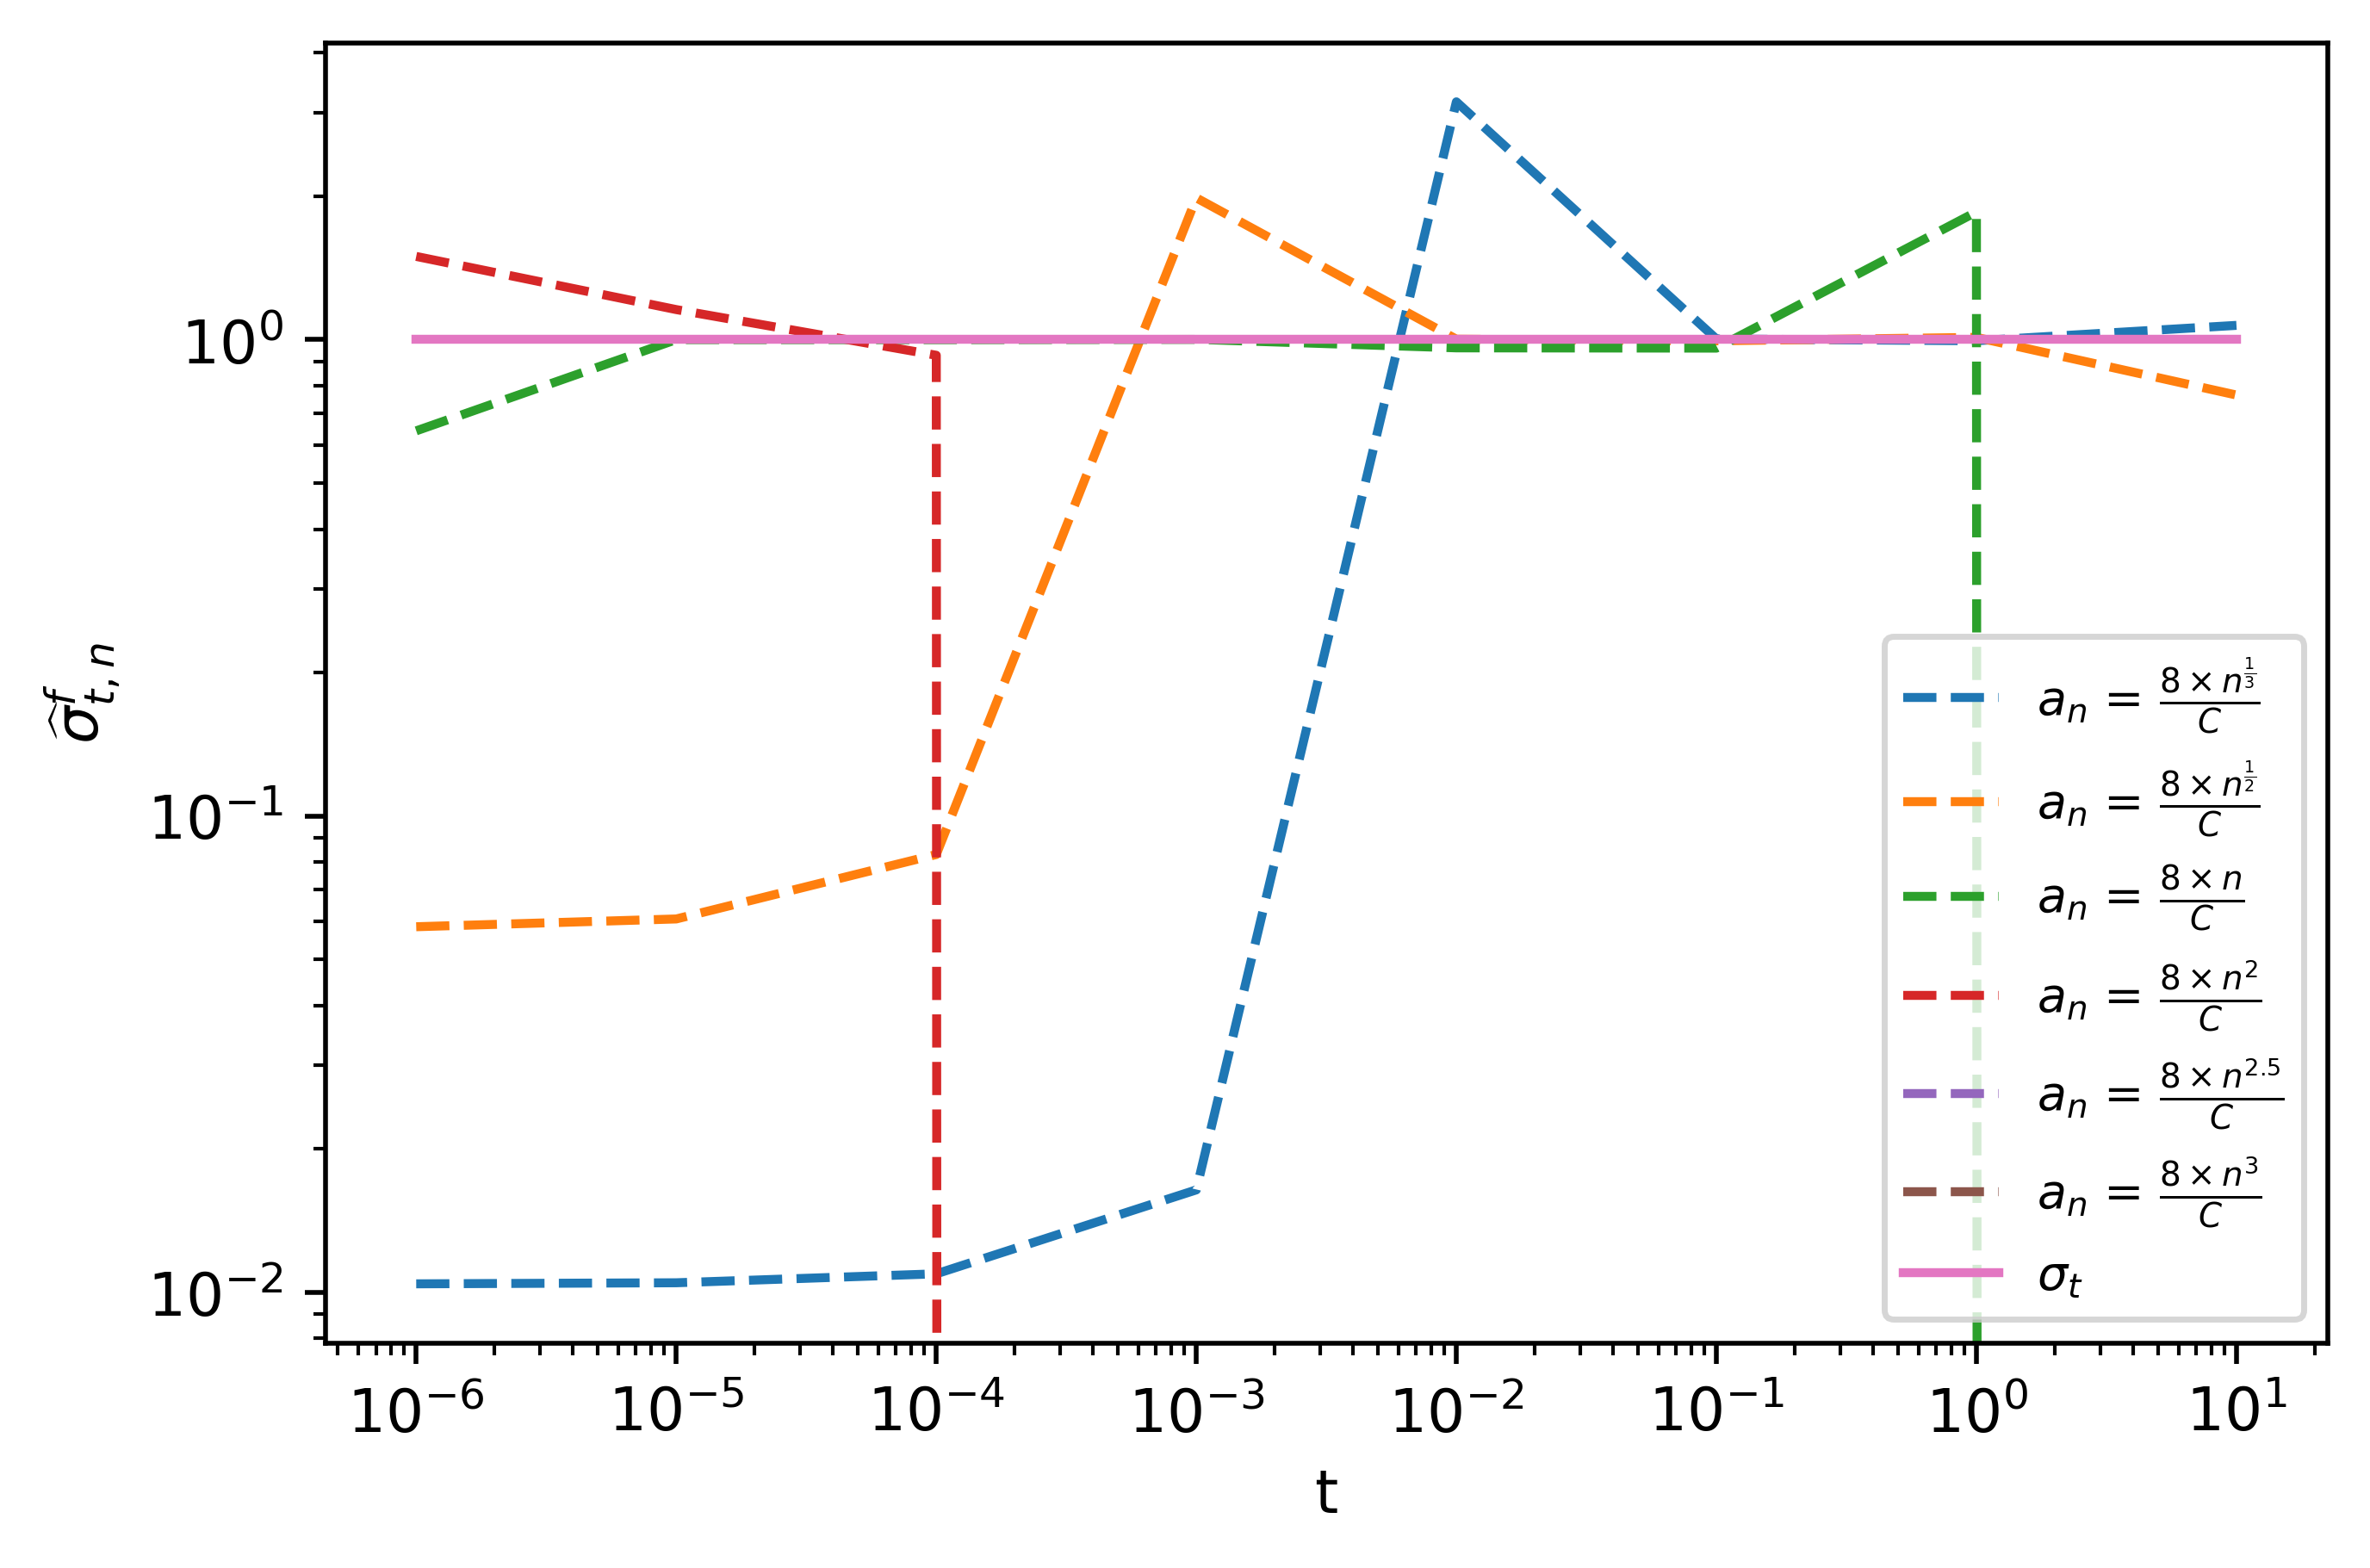

In [22]:
for i in range(0, len(a_ns)):
    
    plt.plot(ts, np.nanmean(sigma_hats_ans[i], axis = 1), label = f'$a_n$ = {labels[i]}', linestyle = types[1])
    print(np.nanmean(sigma_hats_ans[i], axis = 1))
    plt.xlabel('t')
    plt.ylabel('$\widehat{\sigma}_{t, n}^f$')

plt.plot(ts, sigma,
        label = '$\sigma_{t}$')
    
plt.legend(fontsize="8")
plt.xscale('log')
plt.yscale('log')

plt.savefig('../figures/levy/largeNTuning.png', facecolor='w')
plt.show()
plt.close()

In [131]:
print(pd.concat(summaries).to_latex( caption = '',
                        float_format="%.2f",
#                         formatters = {'Mean': "{:.2E}".format,
#                                       'Median': "{:.2E}".format,
#                                       'Bias': "{:.2E}".format,
#                                       'Std': "{:.2E}".format,
#                                       '5.0%': "{:.2E}".format,
#                                       '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lllllrrrrr}
\toprule
     &      &                            &           &                            &  Target &       Mean &         Std &  5.0% &   95% \\
S & n & $a_n$ & t & Statistics &         &            &             &       &       \\
\midrule
\endfirsthead

\toprule
     &      &                            &           &                            &  Target &       Mean &         Std &  5.0% &   95% \\
S & n & $a_n$ & t & Statistics &         &            &             &       &       \\
\midrule
\endhead
\midrule
\multicolumn{10}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
1000 & 1000 & $\frac{8 \times n^{\frac{1}{3}}}{C}$ & 0.000001  & $\widehat{\sigma}_{t,n}^f$ &    1.00 &       0.00 &        0.00 &  0.00 &  0.00 \\
     &      &                            & 0.000010  & $\widehat{\sigma}_{t,n}^f$ &    1.00 &       0.00 &        0.00 &  0.00 &  0.00 \\
     &      &                            & 0.000100  & $\widehat{\sig

<ipython-input-131-74e16fe89875>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(summaries).to_latex( caption = '',


z_sigma feas/infeasible,
report easy to see, for each t, report all S and iterations.


In [ ]:
### k: order of derivatives
### k = 1 for us??
### try with even smaller power, 1/6, 1/7, 1/8, 
### make the range consistent with the rest 10**-6 to 2
### just firx the endpoints and report to the paper.



### try time-varying a_n, 10**-3, 10**-1, purple, red, blue
